In [3]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

Vil anta at ability er eneste grunn til at skolegang er korrelert med feilledd, men vil åpne for at ability kan være korrelert med feilledd. Begynner med å beskrive kausal sammenheng.

\begin{align}
y_i &= \rho s_i + \gamma A_i + \mathbf{x}'\beta \\
&=\rho s_i + \gamma A_i + v^u_i \\
&=E[v^u]+ \rho s_i + \gamma A_i + v^u_i-E[v^u] \\
&= \alpha +\rho s_i + \gamma A_i + v_i
\end{align}

Begge parametrene har kausal tolkning og feilledd har konkret tolkning som (avvik fra gjennomsnittlig) kumulativt bidrag på utfall av alle uobservert variabler. Antagelse om at $cov(s_i,v_i)=0$ er tvilsom siden $cov(s_i,A_i) \neq 0$ og vi ikke vil anta at $cov(A_i,v_i)=0$. 

Siden vi ikke bryr oss om $\gamma$ kan vi definere en ny parameter og lage nytt feilledd som per konstruksjon er ukorrelert med $A_i$,

\begin{align}
v_i &= \xi_0+\xi_1 A_i + (v_i-(\xi_0 +\xi_1A_i)) \\
&= \xi_0+\xi_1 A_i + u_i 
\end{align}

Substituerer det inn i den kausale sammenhengen
\begin{align}
y_i&= (\alpha+\xi_0) +\rho s_i + (\gamma +\xi) A_i + u_i \\
&= \psi +\rho s_i + \phi A_i + u_i
\end{align}
der det nye feilleddet $u_i$ ikke har en like konkret tolkning. Det er ukorrelert med $A_i$ per konstruksjon, og dersom $A_i$ var eneste grunn til at $cov(s_i,v_i)\neq0$ så er det også ukorrelert med $s_i$.

In [74]:
N = 1000000
ρ, γ = 2, 2

a = np.random.normal(size=N) # ability
s = a + np.random.normal(10,size=N) # schooling er korrelert med ability
xβ = a + np.random.normal(1,size=N) # kumulativ bidrag fra andre variabler er korrelert med ability

y = ρ*s +γ*a+xβ # kausal sammenheng

Kan sentrere feilledd

In [75]:
α = np.mean(xβ)
v = xβ-α
np.isclose(y, α+ρ*s+γ*a+v).all()

True

Observerer at $cov(s,v) \neq 0$

In [76]:
np.cov(s,v)[0,1]

0.9942978310294169

Bruker lineær regresjon til å dekomponere feilledd

In [77]:
ξ = sm.OLS(v,sm.add_constant(a)).fit().params
ψ = α+ξ[0]
ϕ = γ+ξ[1]
print(f'ψ={ψ:.2f}\nρ={ρ:.2f}\nϕ={ϕ:.2f}')

ψ=1.00
ρ=2.00
ϕ=3.00


Skal se om det er disse parametrene jeg får av regresjon av $y$ på $(s,A)$

In [78]:
sm.OLS(y,np.c_[np.ones(N),s,a]).fit().params

array([1.000279  , 2.00012673, 2.9988348 ])

bias i kort regresjon

In [80]:
sm.OLS(y,np.c_[np.ones(N),s]).fit().params 

array([-13.97241095,   3.49724242])

In [83]:
ϕ*np.cov(s,a)[0,1]/np.var(s) # tilsvarer differanse i lang og kort

1.4971803137918491

## Del 2

Kan dekomponere feilledd i del som er kosher og del som ikke er kosher selv i krysseksjon. Del som ikke er kosher fanger opp bidrag fra relevante utelatte variabler. Vil visualisere effekt av disse.

Det er poeng at estimat i regresjon avhenger av hvilke variabler vi kontrollere for. I utgangspunktet kan vi tenke at vi vil kontrollere for "alt", noe som motiverer kitchen sink metoden. Det er flere problem med dette. Større problem at det ikke er alt vi observerer...

In [62]:
N = 14
s = np.arange(N)
a = 2*np.r_[-np.ones(7),np.ones(7)]+np.random.normal(size=N)
u = 2*np.random.normal(size=N)

y = s+a+u

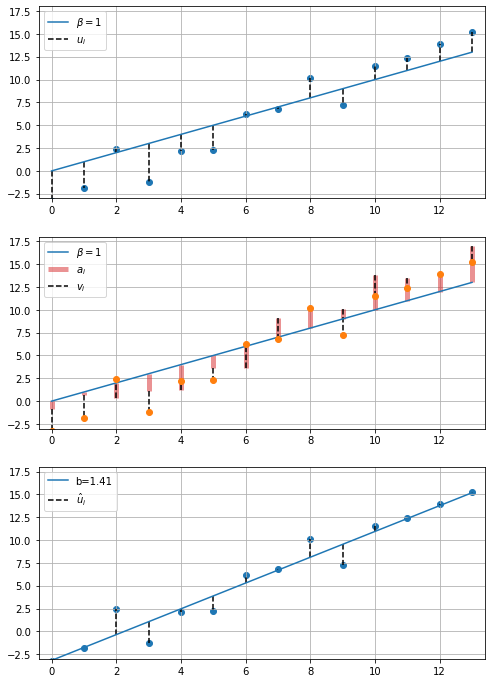

In [75]:
fig,axes = plt.subplots(3,1,figsize=(8,12))
axes = axes.flatten()

axes[0].plot(s,s,label=r'$\beta = 1$')
axes[0].scatter(s,y)
axes[0].vlines(s,s,y,linestyles='dashed',label='$u_i$')
axes[0].legend()

axes[1].plot(s,s,label=r'$\beta = 1$')
axes[1].plot(s,y,'o')
axes[1].vlines(s,s,s+a,linewidth=5,alpha=0.5,label='$a_i$',color='tab:red')
axes[1].vlines(s,y-u,y,linestyles='dashed',label='$v_i$')
axes[1].legend()

params = sm.OLS(y,sm.add_constant(s)).fit().params
axes[2].plot(s,params[0]+params[1]*s,label=f'b={params[1]:.2f}')
axes[2].scatter(s,y)
axes[2].vlines(s,params[0]+params[1]*s,y,linestyles='dashed',label='$\hat{u}_i$')
axes[2].legend()

for ax in axes:
    ax.grid()
    ax.set(xlim=(0-.4,13+.4), ylim=(-3,18))
fig.savefig('OVB.pdf')